In [1]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
from statsmodels.formula.api import ols
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.root_path import config_path, root_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [2]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and source == 'real' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] /1000  # ms to s for better display

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91812, 9)


,id,context_pair,probe,value,metric,site,region,diff_metric,trans_pair
0,ley070a-37-1,00_01,1,0.166028,integral,ley070a,A1,delta_FR,same_silence
1,ley070a-42-1,00_01,1,0.223114,integral,ley070a,A1,delta_FR,same_silence
2,ley070a-04-1,00_02,1,0.326940,integral,ley070a,A1,delta_FR,diff_silence
3,ley070a-10-1,00_02,1,0.251927,integral,ley070a,A1,delta_FR,diff_silence
4,ley070a-12-3,00_02,1,0.359385,integral,ley070a,A1,delta_FR,diff_silence


# Fold
into columns corresponding to categories, as one hot encoding

In [3]:
# grand mean across all data, works to normalize metrics across all data, and transform units from
# integral (z-score * ms) into percentage increase in firing rate.
def norm_by_mean(df):
    normalizer =df.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

    df = pd.merge(df, normalizer, on=['metric'], validate="m:1")
    df['norm_val'] = df['value']/df['grand_mean']

    return df


toregress = norm_by_mean(DF)


def simplify_classified_contexts(df):
    # the simplest approach is to manually map the 4 categories into onehots
    # onehot order: diff1 diff2 same silence
    # mapper={'diff_diff':(1,1,0,0), 'diff_same':(1,0,1,0), 'diff_silence':(1,0,0,1), 'same_silence':(0,0,1,1)}
    # onehot order: diff(any) same silence
    mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}

    df['onehot'] = df['trans_pair'].replace(mapper)

    # onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff1', 'diff2', 'same', 'silence'])
    onehotdf = pd.DataFrame(df['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
    df.drop(columns='onehot', inplace=True)
    df = pd.concat([df, onehotdf], axis=1)

    return df

toregress = simplify_classified_contexts(toregress)

print(toregress.head())

             id context_pair probe     value    metric     site region  \
0  ley070a-37-1        00_01     1  0.166028  integral  ley070a     A1   
1  ley070a-42-1        00_01     1  0.223114  integral  ley070a     A1   
2  ley070a-04-1        00_02     1  0.326940  integral  ley070a     A1   
3  ley070a-10-1        00_02     1  0.251927  integral  ley070a     A1   
4  ley070a-12-3        00_02     1  0.359385  integral  ley070a     A1   

  diff_metric    trans_pair  grand_mean  norm_val  diff  same  silence  
0    delta_FR  same_silence    0.236451  0.702167     0     1        1  
1    delta_FR  same_silence    0.236451  0.943596     0     1        1  
2    delta_FR  diff_silence    0.236451  1.382697     1     0        1  
3    delta_FR  diff_silence    0.236451  1.065452     1     0        1  
4    delta_FR  diff_silence    0.236451  1.519911     1     0        1  


In [4]:
mod = ols("norm_val ~ C(same) + C(silence) + C(region)", data=toregress.query("metric == 'integral'"))
#
# mod = ols("norm_val ~ diff + same + silence + C(region)", data=toregress.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     290.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.43e-187
Time:                        16:05:28   Log-Likelihood:                -54596.
No. Observations:               45906   AIC:                         1.092e+05
Df Residuals:                   45902   BIC:                         1.092e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9020      0.006  

In [5]:
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(same) + C(silence)", data=toregress.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     354.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.83e-153
Time:                        16:10:02   Log-Likelihood:                -54677.
No. Observations:               45906   AIC:                         1.094e+05
Df Residuals:                   45903   BIC:                         1.094e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.

In [8]:
for metric in toregress.metric.unique().tolist():
    print(f"\n#### {metric} ####")
    mod = ols("norm_val ~ C(region)", data=toregress.query(f"metric == '{metric}'"))
    res = mod.fit()
    print(res.summary())


#### integral ####
                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     149.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           2.95e-34
Time:                        16:26:49   Log-Likelihood:                -54954.
No. Observations:               45906   AIC:                         1.099e+05
Df Residuals:                   45904   BIC:                         1.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

## hack
pool data based on a simple clasiffication of containing at least one "diff", "same" or "silence"
thise is odd as it might represent each data point more than one time, but is statistically solid

In [84]:
toplot = list() # concatenate data classified on single values
for cat in ['diff', 'same', 'silence']:
    subset = toregress.query(f"{cat} == 1").copy()
    subset['transition'] = cat
    toplot.append(subset)

toplot = pd.concat(toplot)
print(toplot.head())

             id context_pair probe     value    metric     site region  \
2  ley070a-04-1        00_02     1  0.326940  integral  ley070a     A1   
3  ley070a-10-1        00_02     1  0.251927  integral  ley070a     A1   
4  ley070a-12-3        00_02     1  0.359385  integral  ley070a     A1   
5  ley070a-23-1        00_02     1  0.128487  integral  ley070a     A1   
6  ley070a-37-1        00_02     1  0.152670  integral  ley070a     A1   

  diff_metric    trans_pair  grand_mean  norm_val  diff  same  silence  \
2    delta_FR  diff_silence    0.236451  1.382697     1     0        1   
3    delta_FR  diff_silence    0.236451  1.065452     1     0        1   
4    delta_FR  diff_silence    0.236451  1.519911     1     0        1   
5    delta_FR  diff_silence    0.236451  0.543398     1     0        1   
6    delta_FR  diff_silence    0.236451  0.645671     1     0        1   

  transition  
2       diff  
3       diff  
4       diff  
5       diff  
6       diff  


In [85]:
category = 'transition'
metric = 'integral'
to_stat = dict()
def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn

_ = kruskal_with_posthoc(toplot.query("metric == 'integral'"), group_col='transition', val_col='value')


KruskalResult(statistic=389.00170418878383, pvalue=3.383398947907958e-85)
Dunn post hoc results
                 diff          same       silence
diff     1.000000e+00  3.434265e-07  1.727295e-68
same     3.434265e-07  1.000000e+00  2.842516e-67
silence  1.727295e-68  2.842516e-67  1.000000e+00


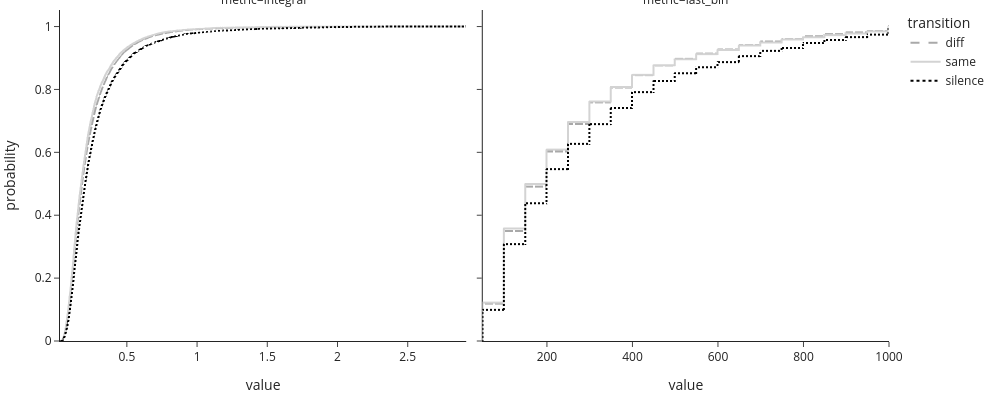

In [86]:
fig = px.ecdf(toplot, x='value', facet_col='metric',
              color='transition', line_dash='transition',
              color_discrete_map={'same': 'lightgray', 'diff':'darkgray', 'silence':'black'},
              line_dash_map={'same': 'solid', 'diff':'dash', 'silence':'dot'},
              category_orders={'metric': ['integral', 'last_bin']})
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  xaxis=dict(matches=None, showticklabels=True),
                  xaxis2=dict(matches=None,)

                  )


img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)


######### integral, transition #########

KruskalResult(statistic=389.00170418878383, pvalue=3.383398947907958e-85)
Dunn post hoc results
                 diff          same       silence
diff     1.000000e+00  3.434265e-07  1.727295e-68
same     3.434265e-07  1.000000e+00  2.842516e-67
silence  1.727295e-68  2.842516e-67  1.000000e+00

######### integral, region #########

KruskalResult(statistic=127.70000803855646, pvalue=1.3055798240314735e-29)
Dunn post hoc results
               A1           PEG
A1   1.000000e+00  1.305580e-29
PEG  1.305580e-29  1.000000e+00

######### last_bin, transition #########

KruskalResult(statistic=234.01905338413138, pvalue=1.5254860042974034e-51)
Dunn post hoc results
                 diff          same       silence
diff     1.000000e+00  5.632052e-01  3.055722e-48
same     5.632052e-01  1.000000e+00  2.686387e-32
silence  3.055722e-48  2.686387e-32  1.000000e+00

######### last_bin, region #########

KruskalResult(statistic=199.4590648894111, pvalue=

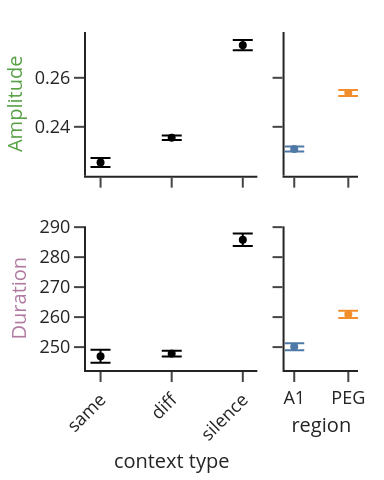

In [87]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(df, metric, category):
    print(f'\n######### {metric}, {category} #########\n')
    df = df.query(f"metric == '{metric}'")

    if category == 'transition':
        ### transitions ###
        _ = kruskal_with_posthoc(df, group_col='transition', val_col='value')
        df = df.groupby(by=['transition'], observed=True).agg(stat=('value', np.mean),
                                                              err=('value', sst.sem))

        x = ['same', 'diff', 'silence']
        y = [df.at[cat, 'stat'] for cat in x]
        yerr = [df.at[cat, 'err'] for cat in x]
        return [
            go.Scatter(x=x, y=y, mode='markers',
                       marker=dict(color='black',
                                   size=4),
                       error_y=dict(array=yerr,
                                    color='black',
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        _ = kruskal_with_posthoc(df, group_col='region', val_col='value')
        df = df.groupby('region').agg(stat=('value', np.mean),
                                      err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for rr, row in df.iterrows():
            reg_quant.append(go.Scatter(x=(rr,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[rr],
                                                    size=4),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[rr],
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')


fig = make_subplots(2, 2, column_width=[0.7, 0.3], shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):
        pan = plot_metric_quant_bars(toplot, met, cat)
        fig.add_traces(pan, cols=[cc + 1] * len(pan), rows=[mm + 1] * len(pan))

w, h = 2, 2.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis=dict(title=dict(text="Amplitude",font_color=AMPCOLOR,)),

                  xaxis3=dict(title=dict(text='context type'), tickangle=-45),
                  yaxis3=dict(title=dict(text='Duration', font_color=DURCOLOR)),

                  xaxis4=dict(title=dict(text='region')),
                  showlegend=False,
                  )

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'fig2_transition_region_effects'
# fig.write_image(filename.with_suffix('.png'), scale=4)
# fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", scale=2)
Image(img_bytes)

# consolidated elsewhere
this last plot has been copied over to 'figure_02.ipynb' for better record keeping.